# Visualization
In this notebook, we use the data organized in the 'clean-data' notebook to make visualziations.

In [1]:
# Numpy and pandas for manipulating the data
import numpy as np
import pandas as pd
import scipy.stats

# Matplotlib and seaborn for visualization
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import plotly
import plotly.plotly as py
import plotly.figure_factory as ff

In [2]:
# First let's read in our clean data
provisions_file = './data/raw/provisions.csv' # We'll need this
lat_long_file = './data/cleaned/lat_long.csv'
annual_file = './data/cleaned/annual_gun.csv'
by_date_norm_file = './data/cleaned/by_date_norm.csv'
by_date_total_file = './data/cleaned/by_date_total.csv'
feature_file = './data/cleaned/features.csv'
overall_file = './data/cleaned/overall.csv'

provisions_df = pd.read_csv(provisions_file, parse_dates=True)
lat_long_df = pd.read_csv(lat_long_file, parse_dates=True, index_col=0)
annual_df = pd.read_csv(annual_file, parse_dates=True, index_col=0)
by_date_norm_df = pd.read_csv(by_date_norm_file, parse_dates=True, index_col=0)
by_date_total_df = pd.read_csv(by_date_total_file, parse_dates=True, index_col=0)
feature_df = pd.read_csv(feature_file, parse_dates=True, index_col=0)
overall_df = pd.read_csv(overall_file, parse_dates=True, index_col=0)

In [3]:
# Styling
# make figures bigger
mpl.rcParams['figure.figsize'] = 12, 8

# change grid line styling
mpl.rcParams['grid.color'] = '#d6dbdf'
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['grid.linewidth'] = 0.5

# make markers smaller
mpl.rcParams['lines.markersize'] = 3

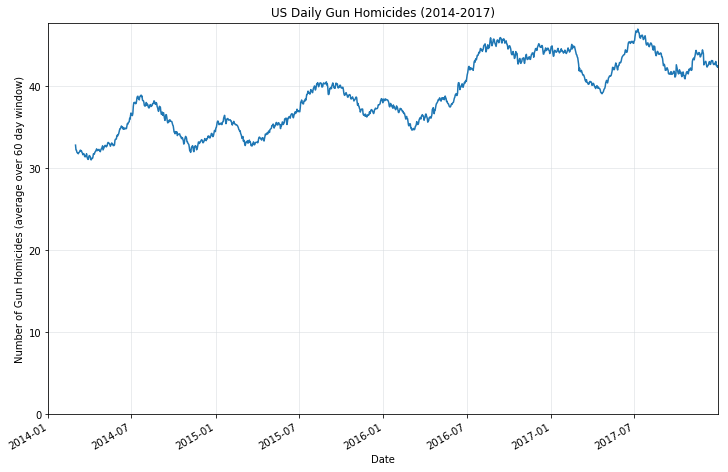

In [4]:
# For our first visualizations, let's just plot the gun homicide trend in two ways:
# Daily mean with window from 2014-2017
win_size = 60

country_gun_df = by_date_total_df['2014':'2017'].sum(axis=1)
country_gun_df.rolling(window=win_size).mean().plot()
plt.title('US Daily Gun Homicides (2014-2017)')
plt.xlabel('Date')
plt.ylabel('Number of Gun Homicides (average over {} day window)'.format(win_size))
plt.ylim(0)
plt.grid()
plt.show()

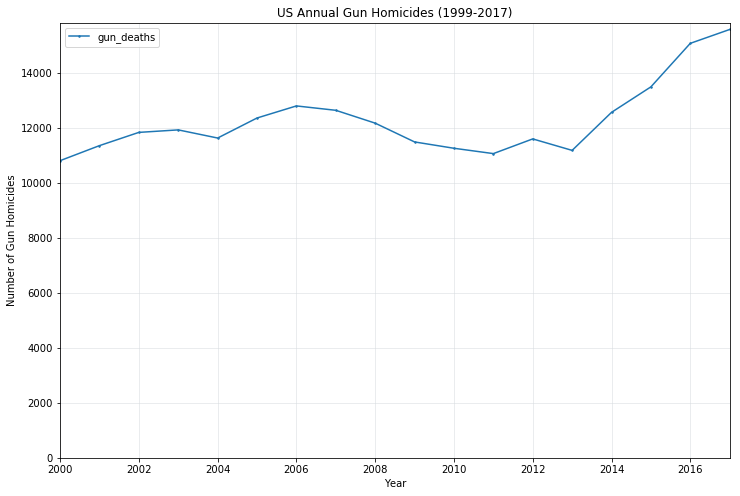

In [5]:
# Annual from 1999-2017
country_annual_df = annual_df[['state', 'year', 'gun_deaths']].groupby('year').sum()
country_annual_df.plot(marker='.')
plt.title('US Annual Gun Homicides (1999-2017)')
plt.xlabel('Year')
plt.ylabel('Number of Gun Homicides')
plt.ylim(0)
# [plt.annotate(int(y), xy=(x, y), textcoords='data') 
#    for x, y in zip(country_annual_df.index, country_annual_df['gun_deaths'])]
plt.grid()
plt.show()

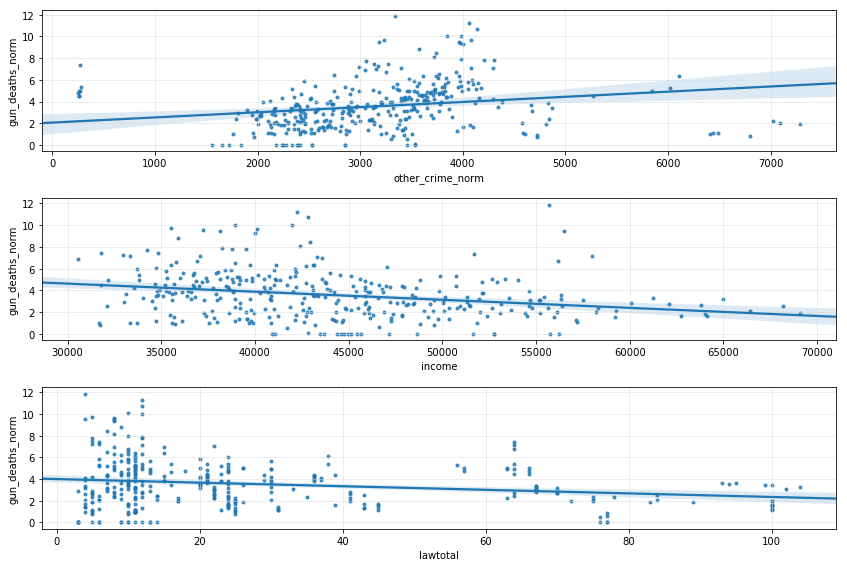

In [6]:
# Plot these features against gun homi
to_plot = ['other_crime_norm', 'income', 'lawtotal']

for i, column in enumerate(to_plot):
    plt.subplot(len(to_plot), 1, i + 1)
    sns.regplot(overall_df[column], overall_df['gun_deaths_norm'])
    plt.grid()

plt.tight_layout()
plt.show()

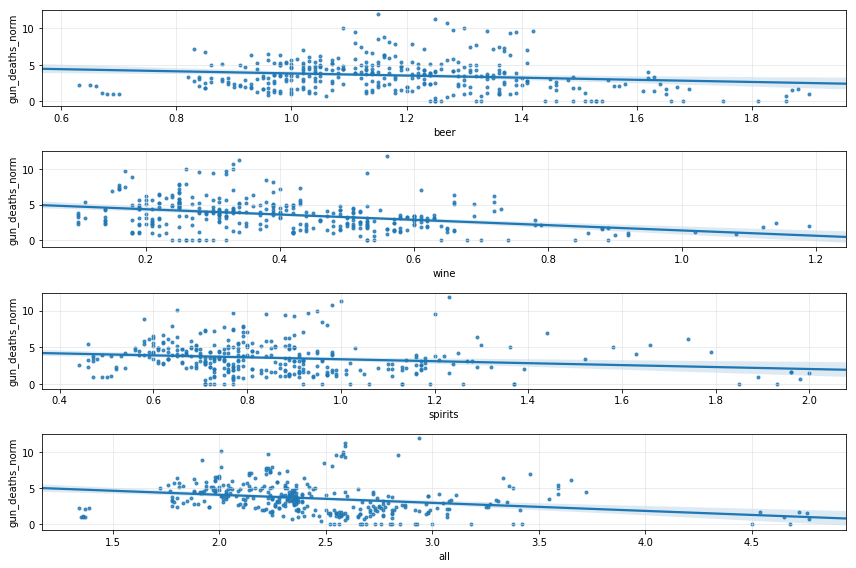

In [7]:
# Plot gun deaths as they relate to alcohol consumption
to_plot = ['beer', 'wine', 'spirits', 'all']
for i, column in enumerate(to_plot):
    plt.subplot(len(to_plot), 1, i + 1)
    sns.regplot(overall_df[column], overall_df['gun_deaths_norm'])
    plt.grid()

plt.tight_layout()
plt.show()

In [8]:
# Plot gun violence as it relates to election results
annual_df['democrat']

0      41.6
1      41.6
2      41.6
3      41.6
4      36.8
5      36.8
6      36.8
7      36.8
8      38.7
9      38.7
10     38.7
11     38.7
12     38.4
13     38.4
14     38.4
15     38.4
16     34.4
17     34.4
18     27.7
19     27.7
20     27.7
21     27.7
22     35.6
23     35.6
24     35.6
25     35.6
26     37.9
27     37.9
28     37.9
29     37.9
       ... 
888    49.7
889    49.7
890    56.2
891    56.2
892    56.2
893    56.2
894    52.8
895    52.8
896    52.8
897    52.8
898    46.5
899    46.5
900    27.7
901    27.7
902    27.7
903    27.7
904    29.1
905    29.1
906    29.1
907    29.1
908    32.5
909    32.5
910    32.5
911    32.5
912    27.8
913    27.8
914    27.8
915    27.8
916    21.6
917    21.6
Name: democrat, Length: 918, dtype: float64

In [9]:
# Threshold number of states to have a law before we examine it
threshold = 15

def compare_provisions(annual_df, provisions_df, threshold=15, year=2017):
    """Return a DataFrame containing difference in population normed gun homicides and p_values
    
    threshold   (int): the minimum number of states that have the provision for it to be included in the 
    results. This prevents misleading results (e.g. laws only Hawaii has) and helps to control for 
    sample size difference.

    year        (int): the year which we should conduct our comparisons in. We focus on one year because we 
    used an independent t-test and observations from the same state across different years are surely not 
    independent, whereas assuming independence of observations from different states is less .   
    """

    # Create a dataframe with 2017 entires 
    provisions = provisions_df.columns[2:-1]
    filtered_df = pd.merge(annual_df, provisions_df)
    filtered_df = filtered_df[filtered_df['year'] == 2017]

    # Remove where provisions sum less than threshold
    provisions = provisions[filtered_df[provisions].sum() > threshold]

    # Lists to keep track of gun homicides for states with and without each law along with the p values
    a_list, b_list, p_list, a_size_list = [], [], [], []

    # Find differences between states w/wo each law
    for p in provisions:
        ab = filtered_df.groupby(p)['gun_deaths_norm'].mean()
        # Append the a and b means to a_list and b_list
        a_list.append(ab[0])
        b_list.append(ab[1])

        # Get a p value using the Welch's t-test; **assumptions of t-test
        without_law = filtered_df[filtered_df[p] == 0]['gun_deaths_norm']
        with_law = filtered_df[filtered_df[p] == 1]['gun_deaths_norm']
        p_list.append(scipy.stats.ttest_ind(without_law, with_law).pvalue)

        a_size_list.append(filtered_df[filtered_df[p] == 0].shape[0])

    # Organize our results in a dataframe to make it easy to read
    results_df = pd.DataFrame()
    results_df['provision'] = provisions
    results_df['without'] = a_list
    results_df['with'] = b_list
    results_df['diff'] = results_df['without'] - results_df['with'] 
    results_df['p_value'] = p_list
    results_df['n_without'] = a_size_list
    results_df = results_df.sort_values('diff', ascending=False)

    return results_df


results = compare_provisions(annual_df, provisions_df, 15, 2017)
results.head()

,provision,without,with,diff,p_value,n_without
14,immunity,5.629389,3.030228,2.599161,0.001455,33
19,nosyg,6.024715,3.466635,2.558080,0.000893,25
26,violentpartial,5.359422,3.441462,1.917959,0.024187,34
24,statechecksh,5.336470,3.490234,1.846237,0.030354,34
18,mcdvdating,5.349055,3.574407,1.774649,0.034754,33


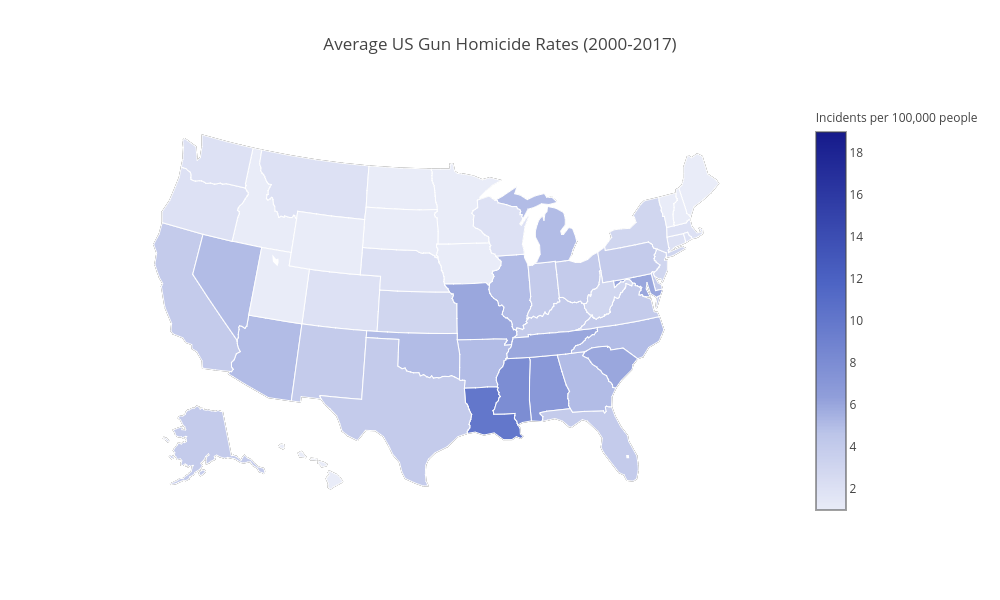

In [10]:
# Map out the normalized crime
# Dictionary to turn state names into abbreviations
states_codes = {
    'Alaska': 'AK', 'Alabama': 'AL', 'Arkansas': 'AR', 'Arizona': 'AZ', 'California': 'CA', 
    'Colorado': 'CO', 'Connecticut': 'CT', 'District of Columbia': 'DC', 'Delaware': 'DE', 
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Iowa': 'IA', 'Idaho': 'ID', 
    'Illinois': 'IL', 'Indiana': 'IN', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 
    'Massachusetts': 'MA', 'Maryland': 'MD', 'Maine': 'ME', 'Michigan': 'MI', 
    'Minnesota': 'MN', 'Missouri': 'MO', 'Northern Mariana Islands': 'MP', 'Mississippi': 'MS', 
    'Montana': 'MT', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Nebraska': 'NE', 
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'Nevada': 'NV', 
    'New York': 'NY', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 
    'Texas': 'TX', 'Utah': 'UT', 'Virginia': 'VA', 'Vermont': 'VT', 'Washington': 'WA', 
    'Wisconsin': 'WI', 'West Virginia': 'WV', 'Wyoming':  'WY'
}

# Create a color scale for aesthetics
colorscale = [
            [0.0, '#e9ecf8'],
            [0.1, '#d3d8f0'],
            [0.2, '#bcc5e9'],
            [0.3, '#909eda'],
            [0.5, '#6377cb'],
            [0.6, 'rgb(77, 100, 196)'],
            [1.0, 'rgb(22, 26, 139)'],
            ]
            
# Mean 2000-2017 murders
annual_mean_df = annual_df.groupby('state').mean().reset_index()
locations = annual_mean_df['state'].apply(lambda x: states_codes[x])
values = annual_mean_df['gun_deaths_norm'].round()

data = [ dict(
        type='choropleth',
        colorscale = colorscale,
        autocolorscale = False,
        locations = locations,
        z = values,
        locationmode = 'USA-states',
        text = annual_mean_df['state'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 1
            ) ),
        colorbar = dict(
            title = "Incidents per 100,000 people")
        )]

layout = dict(
        title = 'Average US Gun Homicide Rates (2000-2017)',
        width = 1000,
        height = 600,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout)

# py.iplot(fig, validate=False, filename='map')
py.image.ishow(fig) # Since py.iplot doesn't work with on GitHub?

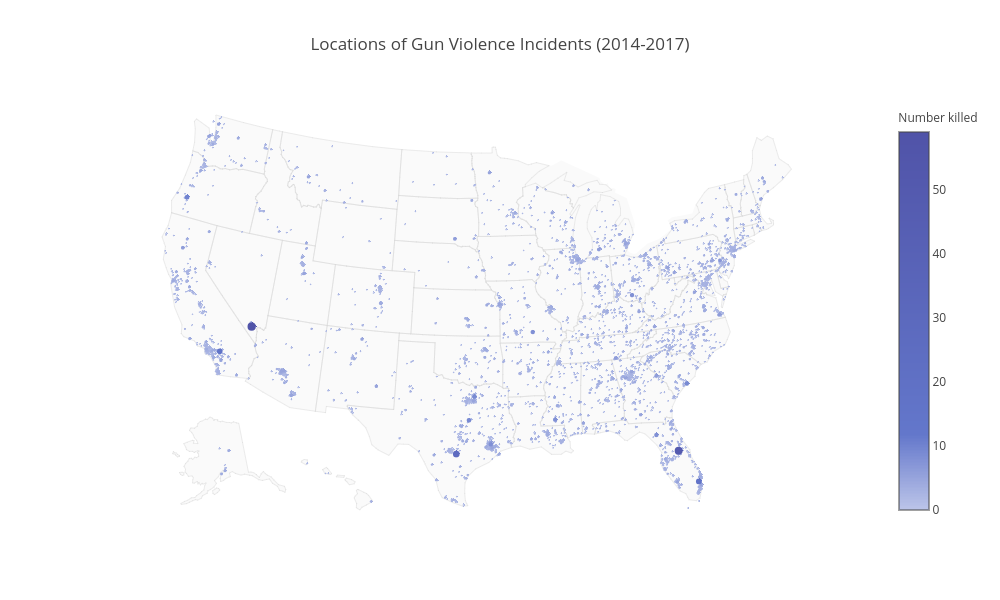

In [20]:
# Create a color scale for aesthetics
colorscale = [
            [0.0, '#bcc5e9'],
            [0.1, '#909eda'],
            [0.2, '#6377cb'],
            [1.0, '#5053a8'],
            ]

# Number of points to sample (getting error from plotly server with too many points)
n_points = 50000
seed = 0

# Get the samples and sort (so large points are plotted on top)
sample_df = lat_long_df[lat_long_df['n_killed'] > 0].sample(n_points, random_state=seed).sort_values('n_killed')

data = [dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lat = sample_df['latitude'],
        lon = sample_df['longitude'],
        text = sample_df['n_killed'],
        mode = 'markers',
        marker = dict(
            size = np.log(sample_df['n_killed']) * 2,
            opacity = 1.0,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width = 0
            ),
            colorscale = colorscale,
            cmin = 0,
            color = sample_df['n_killed'],
            cmax = sample_df['n_killed'].max(),
            colorbar=dict(
                title="Number killed"
            )
        )
        )]

layout = dict(
        title = 'Locations of Gun Violence Incidents (2014-2017)',
        width = 1000,
        height = 600,
        geo = dict(
            scope='usa',
            projection=dict(type='albers usa'),
            showland = True,
            landcolor = '#fafafa',
            subunitcolor = '#d9d9d9',
            countrycolor = '#d9d9d9',
            countrywidth = 1,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
# py.iplot(fig, filename='lat_long_map')
py.image.ishow(fig)